# LSTM Recurrent neural network based integrator simulating SHO (Position Evolution Only)

In [ ]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from Code.dynamical_system import *
from Code.time_integrator import *
from Code.neuralnet_x import *

np.random.seed(2512517)

## Neural network integrator


Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator takes values in $\Delta t_{\text{Verlet}},20\Delta t_{\text{Verlet}},40\Delta t_{\text{Verlet}},100\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training. The output of the neural network is only the position at time $t+1$, excluding velocity. The training data consists of only position values of trajectories generated by the Verlet integrator, using initial velocities taken at random from a normal distribution $N(0,1)$. The network approximates the next state directly, rather than approximating the change in state and summing with the previous state.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 4, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________


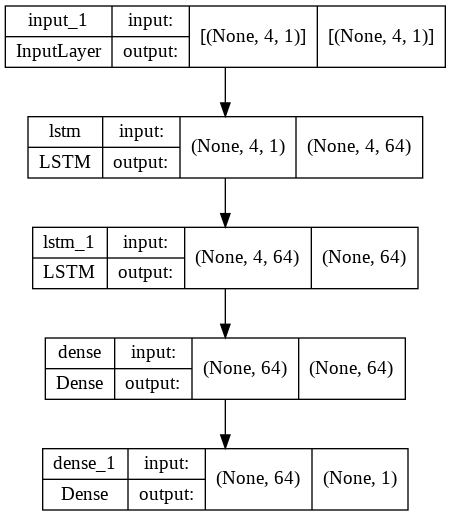

In [ ]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrator
dt_1 = dt_verlet
dt_2 = 20*dt_verlet
dt_3 = 40*dt_verlet
dt_4 = 100*dt_verlet
# number of steps for neural network integrator
nsteps = 4

harmonic_oscillator = HarmonicOscillator(mass,k_spring)

verlet_SHO = VerletIntegrator(harmonic_oscillator,dt_verlet)

lstm_integrator_1 = LSTMStateIntegrator(harmonic_oscillator,nsteps,dt_1)
lstm_integrator_2 = LSTMStateIntegrator(harmonic_oscillator,nsteps,dt_2)
lstm_integrator_3 = LSTMStateIntegrator(harmonic_oscillator,nsteps,dt_3)
lstm_integrator_4 = LSTMStateIntegrator(harmonic_oscillator,nsteps,dt_4)

# visualise the neural network model
lstm_integrator_1.model.summary()
keras.utils.plot_model(lstm_integrator_1.model, show_shapes=True)

In [ ]:
BATCH_SIZE=64

data_generator_1 = DataGenerator(lstm_integrator_1,verlet_SHO)
train_batches_1 = data_generator_1.dataset.batch(BATCH_SIZE)

data_generator_2 = DataGenerator(lstm_integrator_2,verlet_SHO)
train_batches_2 = data_generator_2.dataset.batch(BATCH_SIZE)

data_generator_3 = DataGenerator(lstm_integrator_3,verlet_SHO)
train_batches_3 = data_generator_3.dataset.batch(BATCH_SIZE)

data_generator_4 = DataGenerator(lstm_integrator_4,verlet_SHO)
train_batches_4 = data_generator_4.dataset.batch(BATCH_SIZE)


## Train neural network based integrator


In [ ]:
EPOCHS=300
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result_1 = lstm_integrator_1.model.fit(train_batches_1,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_2 = lstm_integrator_2.model.fit(train_batches_2,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_3 = lstm_integrator_3.model.fit(train_batches_3,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                callbacks=tensorboard_cb)
result_4 = lstm_integrator_4.model.fit(train_batches_4,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)


Epoch 1/300
100/100 [==============================] - 8s 21ms/step - loss: 6.9503
Epoch 2/300
100/100 [==============================] - 2s 22ms/step - loss: 1.3878
Epoch 3/300
100/100 [==============================] - 3s 26ms/step - loss: 0.3030
Epoch 4/300
100/100 [==============================] - 2s 24ms/step - loss: 0.1987
Epoch 5/300
100/100 [==============================] - 2s 22ms/step - loss: 0.0983
Epoch 6/300
100/100 [==============================] - 2s 21ms/step - loss: 0.0817
Epoch 7/300
100/100 [==============================] - 2s 21ms/step - loss: 0.0429
Epoch 8/300
100/100 [==============================] - 3s 26ms/step - loss: 0.0471
Epoch 9/300
100/100 [==============================] - 2s 22ms/step - loss: 0.0338
Epoch 10/300
100/100 [==============================] - 2s 21ms/step - loss: 0.0278
Epoch 11/300
100/100 [==============================] - 2s 21ms/step - loss: 0.0314
Epoch 12/300
100/100 [==============================] - 2s 22ms/step - loss: 0.0216
E

## Visualise Loss function

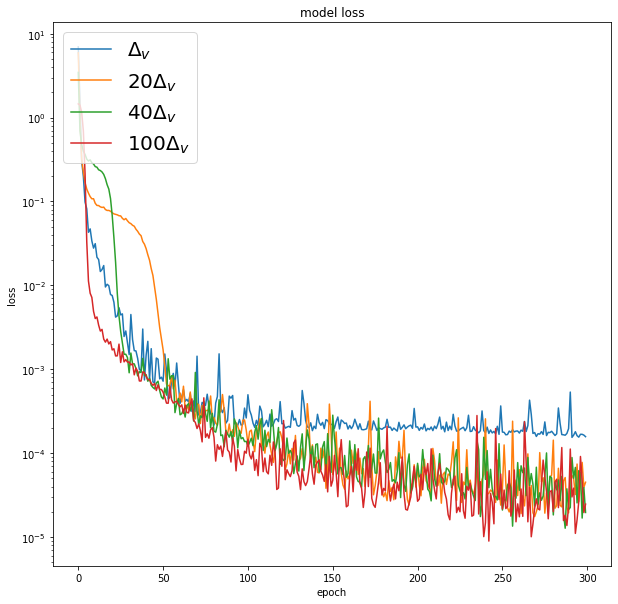

In [ ]:
#print(result.history.keys())

plt.rcParams['figure.figsize'] = [10, 10]

# summarize history for loss
plt.plot(result_1.history['loss'])
plt.plot(result_2.history['loss'])
plt.plot(result_3.history['loss'])
plt.plot(result_4.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.legend(['$\Delta_v$','$20\Delta_v$','$40\Delta_v$','$100\Delta_v$'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories generated to $t=128$ by Verlet integrator and neural 


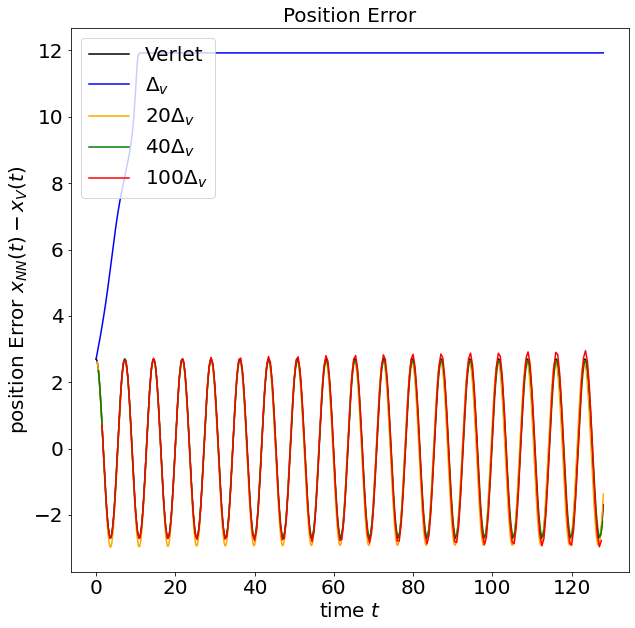

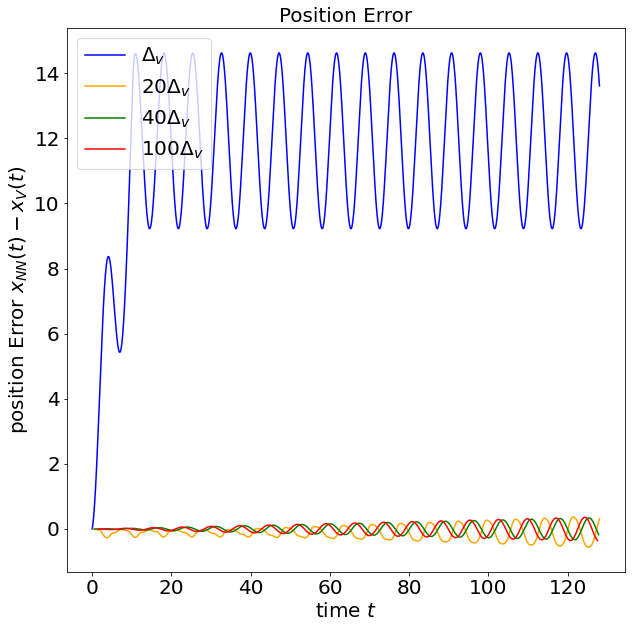

<Figure size 720x720 with 0 Axes>

In [ ]:
# Final time
T_final = 128

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 2.70
v[0] = 0.0
verlet_SHO.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_SHO = []
x_verlet_SHO = []
v_verlet_SHO = []
E_verlet_SHO = []



while t<T_final:
    t_verlet_SHO.append(t)
    E_verlet_SHO.append(verlet_SHO.energy())
    x_verlet_SHO.append(verlet_SHO.x[0])
    v_verlet_SHO.append(verlet_SHO.v[0])
    verlet_SHO.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((lstm_integrator_1.nsteps,lstm_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((lstm_integrator_1.nsteps,lstm_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((lstm_integrator_2.nsteps,lstm_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((lstm_integrator_2.nsteps,lstm_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((lstm_integrator_3.nsteps,lstm_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((lstm_integrator_3.nsteps,lstm_integrator_3.dynamical_system.dim))
x_initial_4 = np.zeros((lstm_integrator_4.nsteps,lstm_integrator_4.dynamical_system.dim))
v_initial_4 = np.zeros((lstm_integrator_4.nsteps,lstm_integrator_4.dynamical_system.dim))



verlet_SHO.set_state(x,v)
for k in range(lstm_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_SHO.x[:]
    v_initial_1[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_1/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(lstm_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_SHO.x[:]
    v_initial_2[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_2/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(lstm_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_SHO.x[:]
    v_initial_3[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_3/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(lstm_integrator_4.nsteps):    
    x_initial_4[k,:] = verlet_SHO.x[:]
    v_initial_4[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_4/dt_verlet))


lstm_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (lstm_integrator_1.nsteps-1)*lstm_integrator_1.dt
lstm_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (lstm_integrator_2.nsteps-1)*lstm_integrator_2.dt
lstm_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (lstm_integrator_3.nsteps-1)*lstm_integrator_3.dt
lstm_integrator_4.set_state(x_initial_4,v_initial_4)
t_4 = (lstm_integrator_4.nsteps-1)*lstm_integrator_4.dt



# Timestepping loop
t_lstm_1 = []
x_lstm_1 = []
v_lstm_1 = []
E_lstm_1 = []
t_lstm_2 = []
x_lstm_2 = []
v_lstm_2 = []
E_lstm_2 = []
t_lstm_3 = []
x_lstm_3 = []
v_lstm_3 = []
E_lstm_3 = []
t_lstm_4 = []
x_lstm_4 = []
v_lstm_4 = []
E_lstm_4 = []


while t_1<T_final:
    t_lstm_1.append(t_1)
    x_lstm_1.append(lstm_integrator_1.x[0])
    lstm_integrator_1.integrate(1)
    t_1 += dt_1
while t_2<T_final:
    t_lstm_2.append(t_2)
    x_lstm_2.append(lstm_integrator_2.x[0])
    lstm_integrator_2.integrate(1)
    t_2 += dt_2
while t_3<T_final:
    t_lstm_3.append(t_3)
    x_lstm_3.append(lstm_integrator_3.x[0])
    lstm_integrator_3.integrate(1)
    t_3 += dt_3
while t_4<T_final:
    t_lstm_4.append(t_4)
    x_lstm_4.append(lstm_integrator_4.x[0])
    lstm_integrator_4.integrate(1)
    t_4 += dt_4
 



x_lstm_1 = np.array(x_lstm_1)
x_lstm_2 = np.array(x_lstm_2)
x_lstm_3 = np.array(x_lstm_3)
x_lstm_4 = np.array(x_lstm_4)
x_verlet_SHO = np.array(x_verlet_SHO)
v_lstm_1 = np.array(v_lstm_1)
v_lstm_2 = np.array(v_lstm_2)
v_lstm_3 = np.array(v_lstm_3)
v_lstm_4 = np.array(v_lstm_4)
v_verlet_SHO = np.array(v_verlet_SHO)


# Plot position  as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(t_verlet_SHO,x_verlet_SHO,label='Verlet',color='black')
plt.plot(t_lstm_1,x_lstm_1,label='$\Delta_v$',color='blue')
plt.plot(t_lstm_2,x_lstm_2,label='$20\Delta_v$',color='orange')
plt.plot(t_lstm_3,x_lstm_3,label='$40\Delta_v$',color='green')
plt.plot(t_lstm_4,x_lstm_4,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot position error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_lstm_1,x_lstm_1-x_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_lstm_2,x_lstm_2-x_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet)::int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_lstm_3,x_lstm_3-x_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet):int(np.size(x_verlet_SHO)-dt_3/dt_verlet):int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_lstm_4,x_lstm_4-x_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()




